In [1]:
!pip install imageio

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [1]:
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from utils import TrainTest, PlotOutput
from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from models.resnet import ResNet18

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# augmentations
# x = datasets.CIFAR10(root='./data', train=True, download=True)

mean = [0.49139968, 0.48215841, 0.44653091] # (x.data.transpose() / 255).reshape(3,-1).mean(-1)
std = [0.24703223, 0.24348513, 0.26158784] # (x.data.transpose() / 255).reshape(3,-1).std(-1)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.ToGray(p=0.2),
        A.PadIfNeeded(40, 40, p=1),
        A.RandomCrop(32, 32, p=1),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, p=1),
        A.Resize(32, 32),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ]
)

In [4]:
from PIL import Image

class ACIFAR10(datasets.CIFAR10):
    def __init__(self, mean, std, **kwargs):
        super(ACIFAR10, self).__init__(**kwargs)
        self.mean = torch.tensor(mean).reshape(len(mean), 1, 1)
        self.std = torch.tensor(std).reshape(len(std), 1, 1)
    
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        
        return img, target

In [5]:
# datasets
trainset = ACIFAR10(
    mean=mean, std=std, root='./data', train=True, download=True, transform=train_transform)

testset = ACIFAR10(
    mean=mean, std=std, root='./data', train=False, download=True, transform=test_transform)

# dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


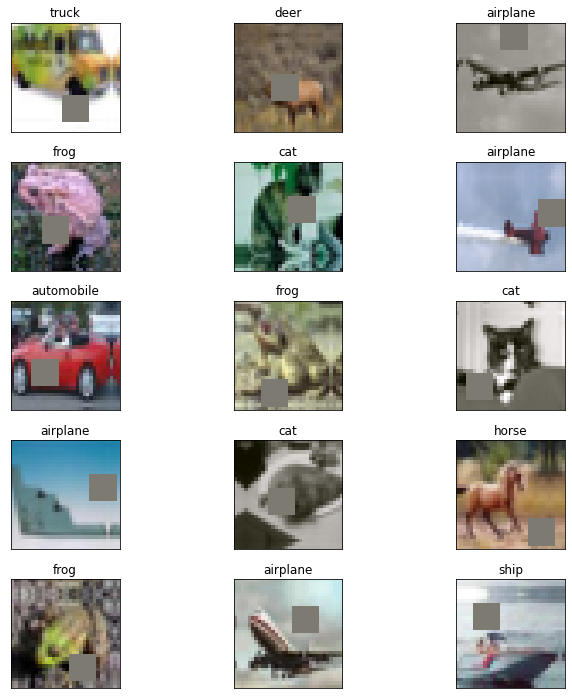

In [6]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label = next(iter(train_loader))

t_std = train_loader.dataset.std
t_mean = train_loader.dataset.mean


for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)
    
    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [7]:
model = ResNet18(dropout=0.).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [8]:
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)

/home/qblocks/.local/lib/python3.8/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-02


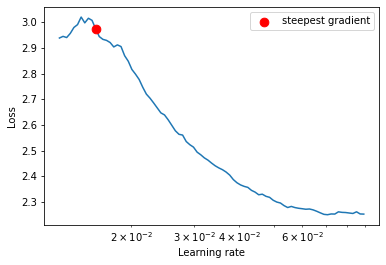

In [9]:
from torch_lr_finder import LRFinder

EPOCHS = 25

def find_lr():
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=0.1, num_iter=100, step_mode='exp')

    _, best_lr = lr_finder.plot()
    lr_finder.reset()
    
    return best_lr 


scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=find_lr(),
            steps_per_epoch=len(train_loader),
            epochs=EPOCHS,
            pct_start=5 / EPOCHS,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )

In [10]:
target_layers = [model.layer4, model.layer3]

run = TrainTest(model=model, 
                trainloader=train_loader, 
                testloader=test_loader, 
                optimizer=optimizer, 
                criterion=criterion, 
                scheduler=scheduler,
                target_layers=target_layers)

image_idx = [15, 25, 446, 416, 96]

run(epochs=EPOCHS, cam=True, image_idx=image_idx)
run.save_grad_cam_gif(image_idx=image_idx, output_directory="./cam_output/")

Train: Loss=1.5386 Batch_id=1562 Accuracy=44.17: 100%|██████████| 1563/1563 [00:38<00:00, 41.03it/s]


Test set: Average loss: 1.3933, Accuracy: 5449/10000 (54.49%)



Train: Loss=1.1305 Batch_id=1562 Accuracy=59.72: 100%|██████████| 1563/1563 [00:49<00:00, 31.78it/s]


Test set: Average loss: 1.0015, Accuracy: 6621/10000 (66.21%)



Train: Loss=0.9385 Batch_id=1562 Accuracy=67.13: 100%|██████████| 1563/1563 [00:56<00:00, 27.57it/s]


Test set: Average loss: 0.8183, Accuracy: 7245/10000 (72.45%)



Train: Loss=0.8437 Batch_id=1562 Accuracy=70.70: 100%|██████████| 1563/1563 [00:55<00:00, 27.98it/s]


Test set: Average loss: 0.8295, Accuracy: 7160/10000 (71.60%)



Train: Loss=0.7778 Batch_id=1562 Accuracy=73.10: 100%|██████████| 1563/1563 [00:55<00:00, 28.11it/s]


Test set: Average loss: 0.7957, Accuracy: 7407/10000 (74.07%)



Train: Loss=0.7160 Batch_id=1562 Accuracy=75.23: 100%|██████████| 1563/1563 [00:56<00:00, 27.88it/s]


Test set: Average loss: 0.6067, Accuracy: 7932/10000 (79.32%)



Train: Loss=0.6437 Batch_id=1562 Accuracy=77.93: 100%|██████████| 1563/1563 [00:56<00:00, 27.54it/s]


Test set: Average loss: 0.4771, Accuracy: 8356/10000 (83.56%)



Train: Loss=0.5832 Batch_id=1562 Accuracy=80.00: 100%|██████████| 1563/1563 [00:56<00:00, 27.80it/s]


Test set: Average loss: 0.4629, Accuracy: 8395/10000 (83.95%)



Train: Loss=0.5406 Batch_id=1562 Accuracy=81.51: 100%|██████████| 1563/1563 [00:57<00:00, 27.35it/s]


Test set: Average loss: 0.4905, Accuracy: 8360/10000 (83.60%)



Train: Loss=0.4942 Batch_id=1562 Accuracy=82.92: 100%|██████████| 1563/1563 [00:57<00:00, 27.27it/s]


Test set: Average loss: 0.4005, Accuracy: 8629/10000 (86.29%)



Train: Loss=0.4530 Batch_id=1562 Accuracy=84.37: 100%|██████████| 1563/1563 [00:55<00:00, 28.23it/s]


Test set: Average loss: 0.3742, Accuracy: 8728/10000 (87.28%)



Train: Loss=0.4210 Batch_id=1562 Accuracy=85.18: 100%|██████████| 1563/1563 [00:55<00:00, 28.19it/s]


Test set: Average loss: 0.3694, Accuracy: 8752/10000 (87.52%)



Train: Loss=0.3946 Batch_id=1562 Accuracy=86.44: 100%|██████████| 1563/1563 [00:56<00:00, 27.61it/s]


Test set: Average loss: 0.3505, Accuracy: 8808/10000 (88.08%)



Train: Loss=0.3675 Batch_id=1562 Accuracy=87.35: 100%|██████████| 1563/1563 [00:56<00:00, 27.67it/s]


Test set: Average loss: 0.3197, Accuracy: 8975/10000 (89.75%)



Train: Loss=0.3376 Batch_id=1562 Accuracy=88.22: 100%|██████████| 1563/1563 [00:57<00:00, 27.23it/s]


Test set: Average loss: 0.3303, Accuracy: 8909/10000 (89.09%)



Train: Loss=0.3141 Batch_id=1562 Accuracy=89.01: 100%|██████████| 1563/1563 [00:56<00:00, 27.45it/s]


Test set: Average loss: 0.3333, Accuracy: 8932/10000 (89.32%)



Train: Loss=0.2884 Batch_id=1562 Accuracy=89.93: 100%|██████████| 1563/1563 [00:56<00:00, 27.59it/s]


Test set: Average loss: 0.2830, Accuracy: 9084/10000 (90.84%)



Train: Loss=0.2718 Batch_id=1562 Accuracy=90.57: 100%|██████████| 1563/1563 [00:57<00:00, 27.20it/s]


Test set: Average loss: 0.2699, Accuracy: 9117/10000 (91.17%)



Train: Loss=0.2517 Batch_id=1562 Accuracy=91.10: 100%|██████████| 1563/1563 [00:58<00:00, 26.90it/s]


Test set: Average loss: 0.2581, Accuracy: 9150/10000 (91.50%)



Train: Loss=0.2301 Batch_id=1562 Accuracy=91.90: 100%|██████████| 1563/1563 [00:57<00:00, 27.25it/s]


Test set: Average loss: 0.2497, Accuracy: 9170/10000 (91.70%)



Train: Loss=0.2135 Batch_id=1562 Accuracy=92.44: 100%|██████████| 1563/1563 [00:57<00:00, 27.33it/s]


Test set: Average loss: 0.2478, Accuracy: 9188/10000 (91.88%)



Train: Loss=0.1955 Batch_id=1562 Accuracy=93.14: 100%|██████████| 1563/1563 [00:56<00:00, 27.87it/s]


Test set: Average loss: 0.2369, Accuracy: 9227/10000 (92.27%)



Train: Loss=0.1807 Batch_id=1562 Accuracy=93.55: 100%|██████████| 1563/1563 [00:55<00:00, 27.99it/s]


Test set: Average loss: 0.2342, Accuracy: 9244/10000 (92.44%)



Train: Loss=0.1625 Batch_id=1562 Accuracy=94.43: 100%|██████████| 1563/1563 [00:56<00:00, 27.84it/s]


Test set: Average loss: 0.2297, Accuracy: 9262/10000 (92.62%)



Train: Loss=0.1560 Batch_id=1562 Accuracy=94.51: 100%|██████████| 1563/1563 [00:56<00:00, 27.47it/s]


Test set: Average loss: 0.2219, Accuracy: 9298/10000 (92.98%)



In [11]:
plot = PlotOutput(model, target_layers=target_layers, device=device)

100%|██████████| 313/313 [00:04<00:00, 63.06it/s]


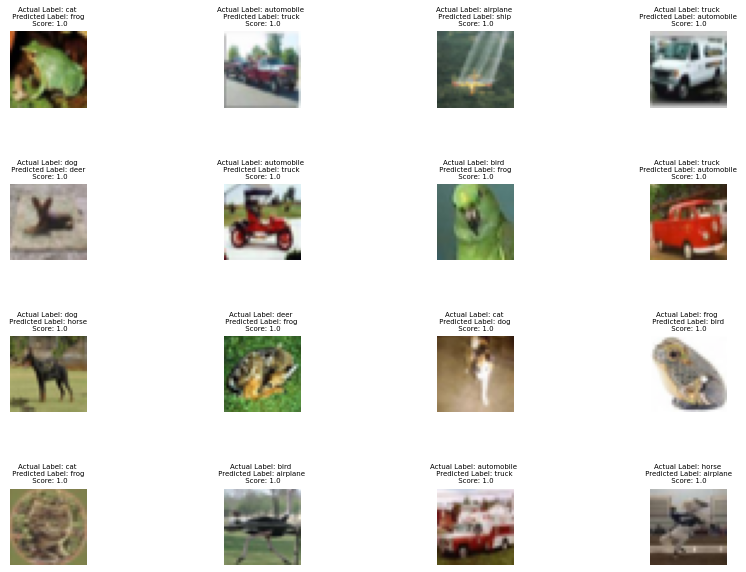

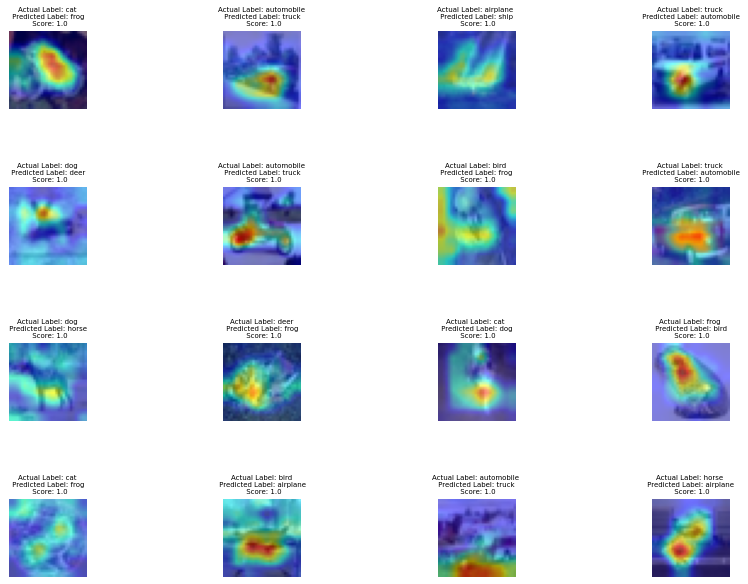

In [12]:
plot.run_prediction(test_loader, ptype="incorrect")

plot.plot(n=16, class_list=classes, grad_cam=False)
plot.plot(n=16, class_list=classes, grad_cam=True)

100%|██████████| 313/313 [00:07<00:00, 44.66it/s]


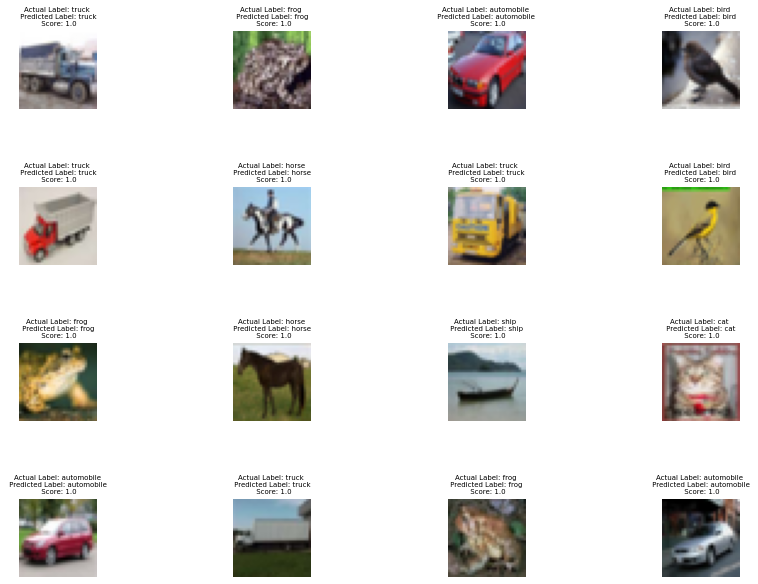

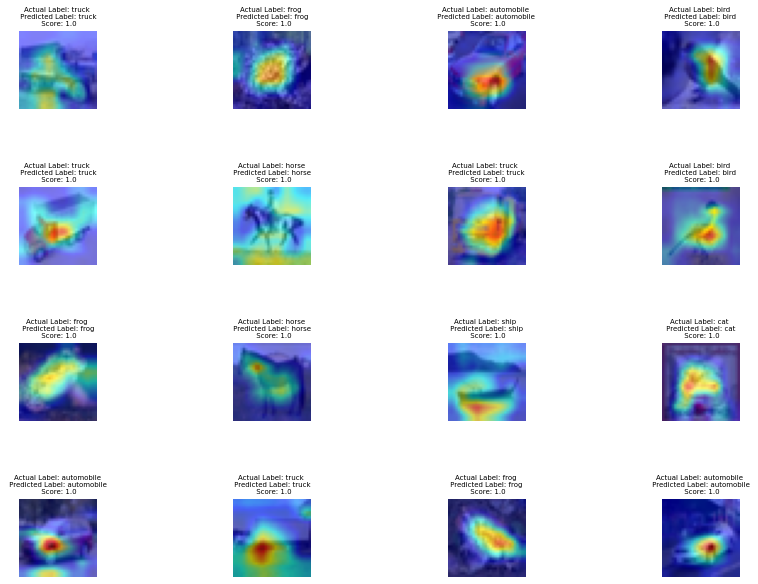

In [13]:
plot.run_prediction(test_loader, ptype="correct")

plot.plot(n=16, class_list=classes, grad_cam=False, reverse=True)
plot.plot(n=16, class_list=classes, grad_cam=True, reverse=True)

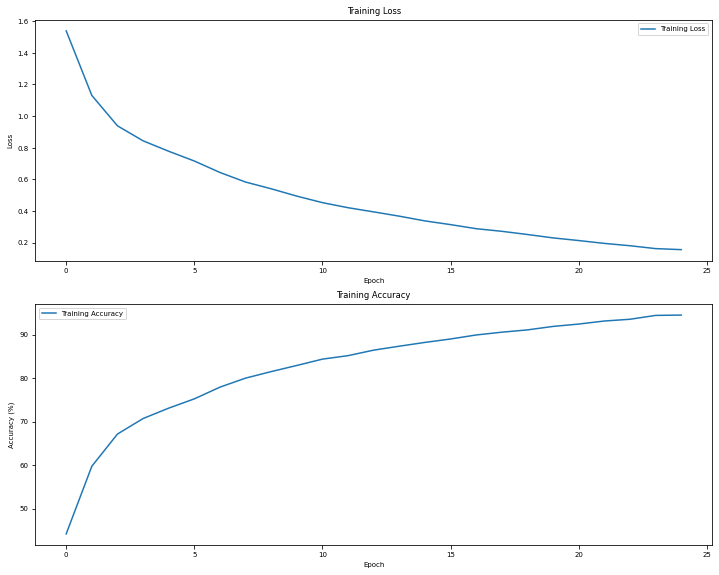

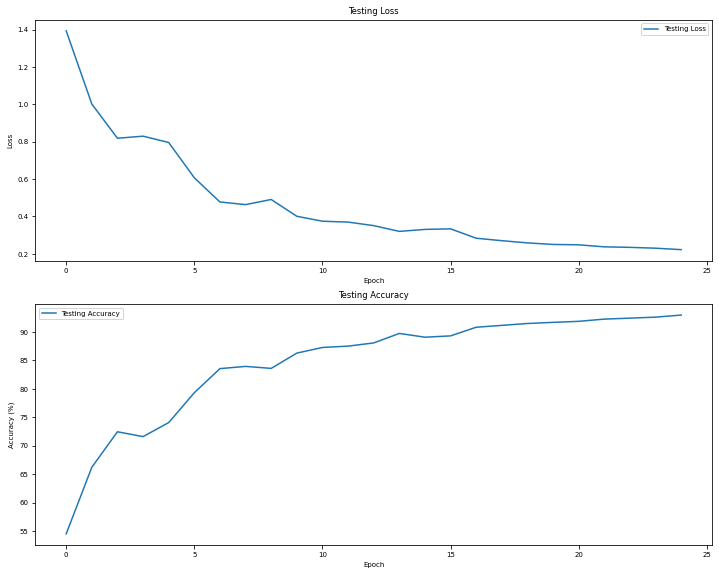

In [14]:
run.train.plot_stats()
run.test.plot_stats()